# first check on data quality for experiment with mixed sensors

Ideally we will get concurrent motion and RR (ECG) from all participants and singer, however devices varied in reliability.

1. Review movesense recordings by set up. 
2. Review delsys recordings by set up and sensor.
3. Align recordings across devices with tapping cue
4. Extract minimum signal (RR) in performance time. (D1)

In [114]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## gather data files

In [ ]:
path = './Equivital/RITMO Extract Data/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))

# First look at the audience Movesense data from iphone

In [30]:
data_loc = './Day1/Movesense_iPhone/'
files = os.listdir(data_loc)
k = []
for f in files:
    c = f.split('_')
    st = dt.datetime.strptime(c[0][:-1],'%Y%m%dT%H%M%S')
    devID = int(c[1])
    fl = {'Signal':c[2],'StartTime':st,'daytime':int(c[0][9:15]),'date':int(c[0][:8]),'Device':devID,'File':f}
    k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,daytime,date,Device,File
0,acc,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_acc_stream.json
1,heartRate,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_heartRate_stream...
2,ecg,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_ecg_stream.json
3,heartRate,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_heartRate_stream...
4,acc,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_acc_stream.csv
5,ecg,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_ecg_stream.json
6,acc,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_acc_stream.csv
7,ecg,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_ecg_stream.csv
8,acc,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_acc_stream.json
9,heartRate,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_heartRate_stream...


In [39]:
dev = df_files.loc[2,'Device']
session_files =  df_files.loc[df_files['Device'] == dev,:].reset_index(drop=True)
session_files 

,Signal,StartTime,daytime,date,Device,File
0,ecg,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_ecg_stream.json
1,acc,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_acc_stream.csv
2,ecg,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_ecg_stream.csv
3,acc,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_acc_stream.json
4,heartRate,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_heartRate_stream...
5,heartRate,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_heartRate_stream...


                  x         y         z
timestamp                              
0         -1.009807  9.447201  1.864075
9         -1.060058  9.408915  1.866468
19        -1.043308  9.408915  1.892790
29        -1.014593  9.428058  1.864075


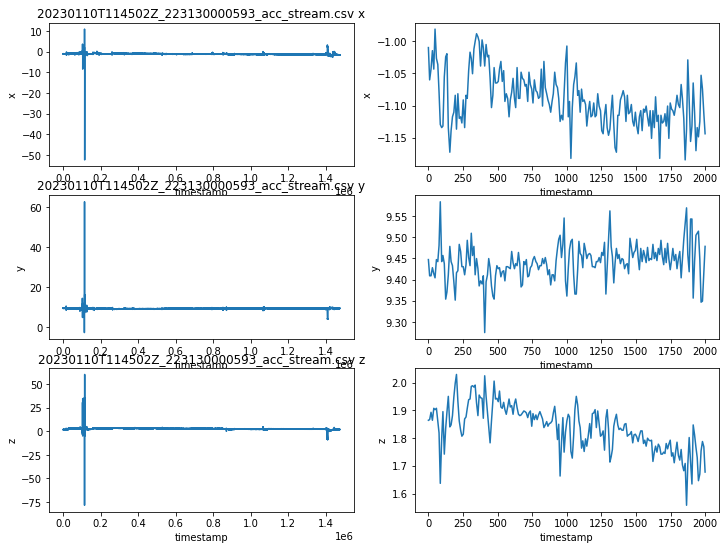

           sample
timestamp        
0            -259
1            -260
3            -262
5            -263


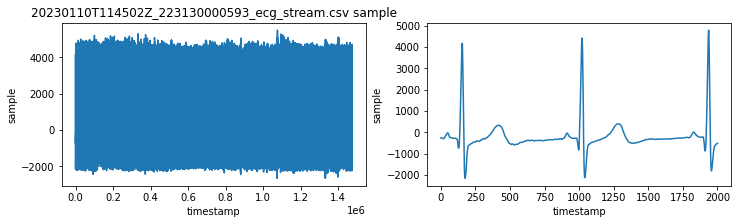

     average  rrData
0  67.300000     921
1  66.200005     945
2  64.600000     984
3  64.300000     945


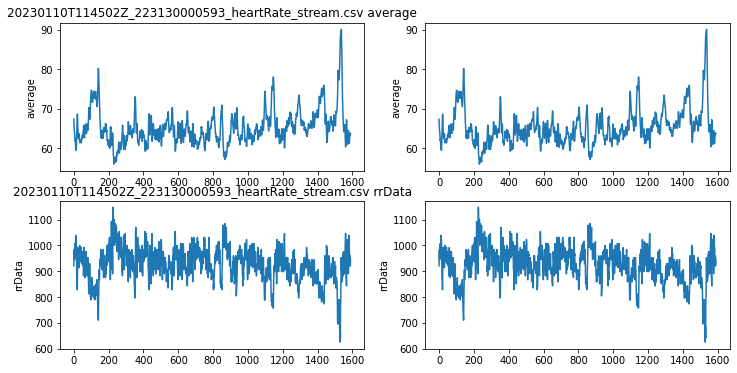

In [40]:
for i in range(len(session_files)):
    sessF =session_files.loc[i,'File']
    if sessF .endswith('.csv'):
        data = pd.read_csv(data_loc + sessF)
        dets = sessF.split('_')
        if 'timestamp' in data.columns:
            data['timestamp'] = (data['timestamp']-data.loc[0,'timestamp'])
            data.set_index('timestamp',inplace = True)
        print(data.iloc[:4,:])
        feats = data.columns
        sub_data = data.loc[:2000,:]
        fig, ax = plt.subplots(len(feats),2,figsize=[12,3*len(feats)])
        if len(feats)>1:
            for i in range(len(feats)):
                feat =feats[i]
                a = ax[i,0]
                data[feat].plot(ax = a)
                a.set_ylabel(feat)
                a.set_title(sessF + ' ' + feat)
                a = ax[i,1]
                sub_data[feat].plot(ax = a)
                a.set_ylabel(feat)
            plt.savefig('plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
            plt.show()
        else:
            feat = feats[0]
            a = ax[0]
            data[feat].plot(ax = a)
            a.set_ylabel(feat)
            a.set_title(sessF + ' ' + feat)
            a = ax[1]
            sub_data[feat].plot(ax = a)
            a.set_ylabel(feat)
            plt.savefig('plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
            plt.show()            

# Movesense on singer

In [41]:
data_loc = './Day1/Movesense_Singer_iPhone/'
files = os.listdir(data_loc)
k = []
for f in files:
    c = f.split('_')
    st = dt.datetime.strptime(c[0][:-1],'%Y%m%dT%H%M%S')
    devID = int(c[1])
    fl = {'Signal':c[2],'StartTime':st,'daytime':int(c[0][9:15]),'date':int(c[0][:8]),'Device':devID,'File':f}
    k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,daytime,date,Device,File
0,ecg,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_ecg_stream.csv
1,acc,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_acc_stream.csv
2,heartRate,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_heartRate_stream...


In [42]:
dev = df_files.loc[1,'Device']
session_files =  df_files.loc[df_files['Device'] == dev,:].reset_index(drop=True)
session_files 

,Signal,StartTime,daytime,date,Device,File
0,ecg,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_ecg_stream.csv
1,acc,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_acc_stream.csv
2,heartRate,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_heartRate_stream...


           sample
timestamp        
0            -383
2            -384
4            -392
6            -403


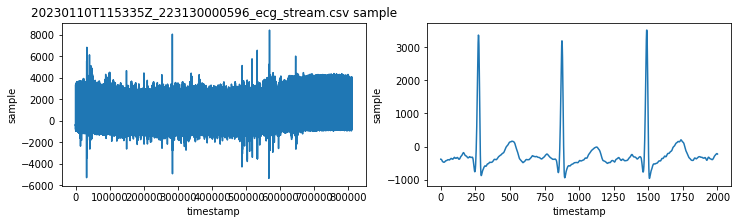

                  x         y         z
timestamp                              
0          1.081595  9.260554  1.825789
9          0.928448  9.317985  1.710929
18         0.842304  9.389771  1.832968
28         0.705908  9.313198  2.103366


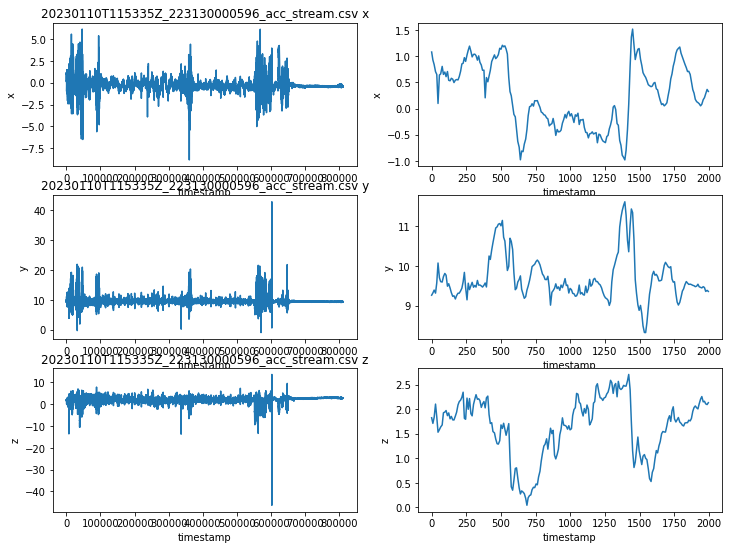

     average  rrData
0  98.600000     616
1  98.200005     616
2  98.000000     616
3  97.500000     624


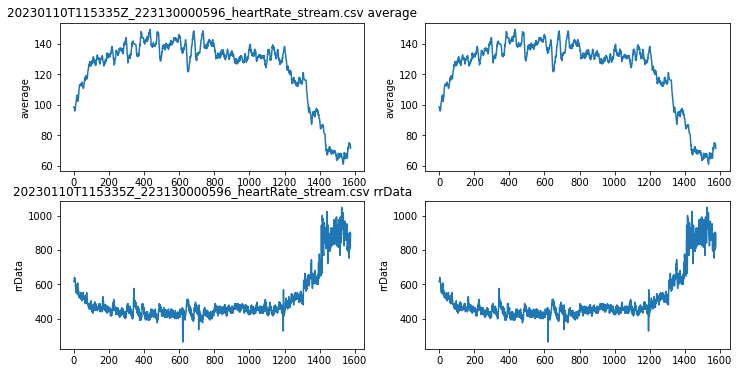

In [43]:
for i in range(len(session_files)):
    sessF =session_files.loc[i,'File']
    if sessF .endswith('.csv'):
        data = pd.read_csv(data_loc + sessF)
        dets = sessF.split('_')
        if 'timestamp' in data.columns:
            data['timestamp'] = (data['timestamp']-data.loc[0,'timestamp'])
            data.set_index('timestamp',inplace = True)
        print(data.iloc[:4,:])
        feats = data.columns
        sub_data = data.loc[:2000,:]
        fig, ax = plt.subplots(len(feats),2,figsize=[12,3*len(feats)])
        if len(feats)>1:
            for i in range(len(feats)):
                feat =feats[i]
                a = ax[i,0]
                data[feat].plot(ax = a)
                a.set_ylabel(feat)
                a.set_title(sessF + ' ' + feat)
                a = ax[i,1]
                sub_data[feat].plot(ax = a)
                a.set_ylabel(feat)
            plt.savefig('plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
            plt.show()
        else:
            feat = feats[0]
            a = ax[0]
            data[feat].plot(ax = a)
            a.set_ylabel(feat)
            a.set_title(sessF + ' ' + feat)
            a = ax[1]
            sub_data[feat].plot(ax = a)
            a.set_ylabel(feat)
            plt.savefig('plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
            plt.show()            

# Movesense from andriod showcase


In [61]:
data_loc = './Day1/Movesense_Andriod/'
# 'A10_07_2023-11-23_10-14-12_223130000599_HeartRateTestActivity.csv'
files = os.listdir(data_loc)
k = []
for f in files:
    c = f.split('_')
    if len(c)>4:
        st = dt.datetime.strptime(c[2],'%Y-%m-%d')
        devID = int(c[4])
        fl = {'Signal':c[5][:-4],'StartTime':st,'daytime':c[3],'date':c[2],'Device':devID,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,daytime,date,Device,File
0,EcgActivityGraphView,2023-01-10,11-11-56,2023-01-10,223130000576,A10_09_2023-01-10_11-11-56_223130000576_EcgAct...
1,HeartRateTestActivity,2023-11-23,10-14-12,2023-11-23,223130000599,A10_07_2023-11-23_10-14-12_223130000599_HeartR...
2,LinearAccelerationTestActivity,2023-11-23,10-14-18,2023-11-23,223130000599,A10_07_2023-11-23_10-14-18_223130000599_Linear...
3,EcgActivityGraphView,2023-11-23,10-15-30,2023-11-23,223130000599,A10_07_2023-11-23_10-15-30_223130000599_EcgAct...
4,EcgActivityGraphView,2023-11-23,12-22-17,2023-11-23,223130000577,A10_07_2023-11-23_12-22-17_223130000577_EcgAct...
5,LinearAccelerationTestActivity,2023-11-23,10-14-15,2023-11-23,223130000599,A10_07_2023-11-23_10-14-15_223130000599_Linear...


In [62]:
files

['Sensor_Plan.xlsx',
 'A10_07_2023-11-23_10-14-12_223130000599_HeartRateTestActivity.csv',
 'A10_07_2023-11-23_10-14-18_223130000599_LinearAccelerationTestActivity.csv',
 'A10_07_2023-11-23_10-15-30_223130000599_EcgActivityGraphView.csv',
 'A10_07_2023-11-23_12-22-17_223130000577_EcgActivityGraphView.csv',
 'A10_09_2023-01-10_11-11-56_223130000576_EcgActivityGraphView.csv',
 'A10_07_2023-11-23_10-14-15_223130000599_LinearAccelerationTestActivity.csv']

   Timestamp  Count
0     115892      0
1     115900      0
2     115908     -1
3     115915     -2


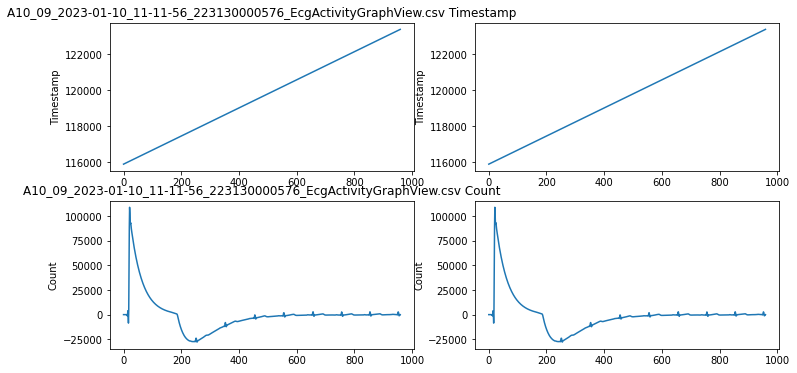

Empty file: A10_07_2023-11-23_10-14-12_223130000599_HeartRateTestActivity.csv
Empty file: A10_07_2023-11-23_10-14-18_223130000599_LinearAccelerationTestActivity.csv
Empty file: A10_07_2023-11-23_10-15-30_223130000599_EcgActivityGraphView.csv
Empty file: A10_07_2023-11-23_12-22-17_223130000577_EcgActivityGraphView.csv
Empty file: A10_07_2023-11-23_10-14-15_223130000599_LinearAccelerationTestActivity.csv


In [68]:
for i in range(len(df_files)):
    sessF =df_files.loc[i,'File']
    if os.stat(data_loc+sessF).st_size == 0:
        print('Empty file: ' + sessF)
    else:
        data = pd.read_csv(data_loc + sessF)
        dets = sessF.split('_')
        if 'timestamp' in data.columns:
            data['timestamp'] = (data['timestamp']-data.loc[0,'timestamp'])
            data.set_index('timestamp',inplace = True)
        print(data.iloc[:4,:])
        feats = data.columns
        sub_data = data.loc[:2000,:]
        fig, ax = plt.subplots(len(feats),2,figsize=[12,3*len(feats)])
        if len(feats)>1:
            for i in range(len(feats)):
                feat =feats[i]
                a = ax[i,0]
                data[feat].plot(ax = a)
                a.set_ylabel(feat)
                a.set_title(sessF + ' ' + feat)
                a = ax[i,1]
                sub_data[feat].plot(ax = a)
                a.set_ylabel(feat)
            plt.savefig('plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
            plt.show()
        else:
            feat = feats[0]
            a = ax[0]
            data[feat].plot(ax = a)
            a.set_ylabel(feat)
            a.set_title(sessF + ' ' + feat)
            a = ax[1]
            sub_data[feat].plot(ax = a)
            a.set_ylabel(feat)
            plt.savefig('plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
            plt.show()  

# Data logger files check 

In [69]:
# I'm still unsure of what the timestamps mean given the lack of sample rate
# or whether there is a better way of interpolating stamp values to match the batchs recorded.
# also might be nice to have some metadata if we do write our own export apps.

def switch(signal_tag,ml_data):
    if signal_tag == 'ecg':
        samples=16
        step = np.floor(ml_data['ecg.Timestamp'].diff().mean()/samples)
        times = ml_data['ecg.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(columns = [signal_tag],data = ml_data.loc[:,'ecg.Samples'].sum())
        sig_df['timestamps']=TimeStamps
        return sig_df
    if signal_tag == 'heartRate':
        sig_df = pd.DataFrame()
        sig_df['heartRate'] =ml_data['heartRate.average']
        sig_df['rrData'] =ml_data['heartRate.rrData'].sum()
        sig_df['timestamps']=ml_data.index
        return sig_df
    elif signal_tag == 'magn':
        samples=4
        step = np.floor(ml_data['magn.Timestamp'].diff().mean()/samples)
        times = ml_data['magn.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(data = ml_data.loc[:,'magn.ArrayMagn'].sum())
        sig_df.rename(columns={'x':'Magn_x','y':'Magn_y','z':'Magn_z'},inplace=True)
        sig_df['timestamps']=TimeStamps
        return sig_df
    elif signal_tag == 'gyro':
        samples=4
        step = np.floor(ml_data['gyroscope.Timestamp'].diff().mean()/samples)
        times = ml_data['gyroscope.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(data = ml_data.loc[:,'gyroscope.ArrayGyro'].sum())
        sig_df.rename(columns={'x':'Gyro_x','y':'Gyro_y','z':'Gyro_z'},inplace=True)
        sig_df['timestamps']=TimeStamps
        return sig_df
    elif signal_tag == 'acc':
        samples=4
        step = np.floor(ml_data['acc.Timestamp'].diff().mean()/samples)
        times = ml_data['acc.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(data = ml_data.loc[:,'acc.ArrayAcc'].sum())
        sig_df.rename(columns={'x':'Acc_x','y':'Acc_y','z':'Acc_z'},inplace=True)
        sig_df['timestamps']=TimeStamps
        return sig_df
    elif signal_tag == 'imu':
        samples=4
        step = np.floor(ml_data['imu.Timestamp'].diff().mean()/samples)
        times = ml_data['imu.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig1_df = pd.DataFrame(data = ml_data.loc[:,'imu.ArrayAcc'].sum())
        sig1_df.rename(columns={'x':'Acc_x','y':'Acc_y','z':'Acc_z'},inplace=True)
        sig2_df = pd.DataFrame(data = ml_data.loc[:,'imu.ArrayGyro'].sum())
        sig2_df.rename(columns={'x':'Gyro_x','y':'Gyro_y','z':'Gyro_z'},inplace=True)

        sig_df = pd.concat([sig1_df,sig2_df],axis=1)
        sig_df['timestamps']=TimeStamps
        return sig_df
    else:
        print('Not familiar signal')
        return

In [94]:
data_loc = './Day1/Movesense_dataLogger/'
# 'MovesenseLog_2 2023-01-10 16_47_37.json'
files = os.listdir(data_loc)
k = []
for f in files:
    c = f.split(' ')
    if len(c)<4:
        st = dt.datetime.strptime(c[1],'%Y-%m-%d')
        devID = 'NA' #int(c[4])
        fl = {'Signal':'NA','StartTime':st,'daytime':c[2],'date':c[1],'Device':devID,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files


,Signal,StartTime,daytime,date,Device,File
0,NA,2023-01-10,16_47_37.json,2023-01-10,NA,MovesenseLog_2 2023-01-10 16_47_37.json
1,NA,2023-01-10,11_12_31.json,2023-01-10,NA,MovesenseLog_3 2023-01-10 11_12_31.json


In [109]:
i = 0
signal_tag = 'acc'
file = files[0]
with open(data_loc + file,'r') as f:
    data = json.loads(f.read())
rec_time = dt.datetime.strptime(c[1][:-1]+c[2][:8],'%Y-%m-%d%H_%M_%S')
ml_data = pd.json_normalize(data['Meas']['Acc'])

samples=4
step = np.floor(ml_data['Timestamp'].diff().mean()/samples)
times = ml_data['Timestamp']
TimeStamps = pd.DataFrame()
for i in range(samples):
    TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

sig_df = pd.DataFrame(data = ml_data.loc[:,'ArrayAcc'].sum())
sig_df.rename(columns={'x':'Acc_x','y':'Acc_y','z':'Acc_z'},inplace=True)
sig_df['timestamps']=TimeStamps



0      25974.0
100    27865.0
Name: timestamps, dtype: float64


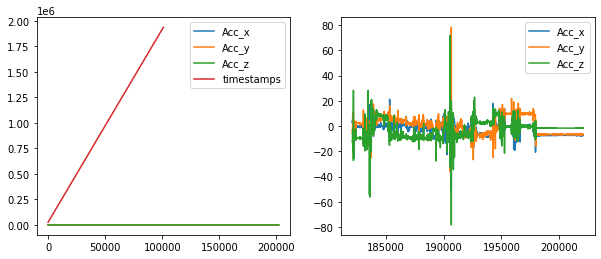

In [112]:
print(sig_df.loc[[0,100],'timestamps'])
fig, (ax1, ax2)=plt.subplots(1,2,figsize=[10,4])
sig_df.plot(ax = ax1)
sig_df.iloc[-20000:,:-1].plot(ax = ax2)
plt.show()

In [113]:
sig_df.columns

Index(['Acc_x', 'Acc_y', 'Acc_z', 'timestamps'], dtype='object')